In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
fontsize = 20
from functools import partial, reduce
# compose = lambda *F: reduce(lambda f, g: lambda x: f(g(x)), F)
from funcy import compose
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy.signal import savgol_filter, periodogram
from scipy import interpolate
from scipy.integrate import trapz
from scipy.stats import wilcoxon, ranksums, mannwhitneyu, friedmanchisquare
from numpy.fft import fft, ifft, fftfreq
from time import time
from tqdm import tqdm

from tqdm import trange
from best_subset import *
from solvel0 import solvel0
from pde_diff_new import RPCA
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff
import pynumdiff
import pynumdiff.optimize
import sys; sys.path.insert(0, "../derivative/"); import derivative
from derivative import dxdt as ddd

from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.preprocessing import normalize as sk_normalize
from sklearn.utils.random import sample_without_replacement

from findiff import FinDiff
# from abess.linear import LinearRegression
from UBIC import fit_blr, UBIC, decreasing_values_indices
# from skscope_tools import best_subset_all_solutions, abess_all_solutions
from para_UBIC import *
from mdl_comp import RidgeMDLCOMP

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

np.random.seed(1234)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.4.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.
Best-subset solvers are NOT installed.


In [2]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv = a*(1+c*np.sin(t))*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u))
    return real(deriv)

# Set size of grid -> affect discovery results
n = 256
m = 256
    
# Set up grid
x = np.linspace(-8,8,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,10,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x+1)**2)

# Solve with time dependent uu_x term
params = (k, -1, 0.1, 0.25)
u = odeint(parametric_burgers_rhs, u0, t, args=(params,)).T # shape = (len(x), len(t))

u_xx_true = 0.1*np.ones(m)
uu_x_true = -1*(1+0.25*np.sin(t))

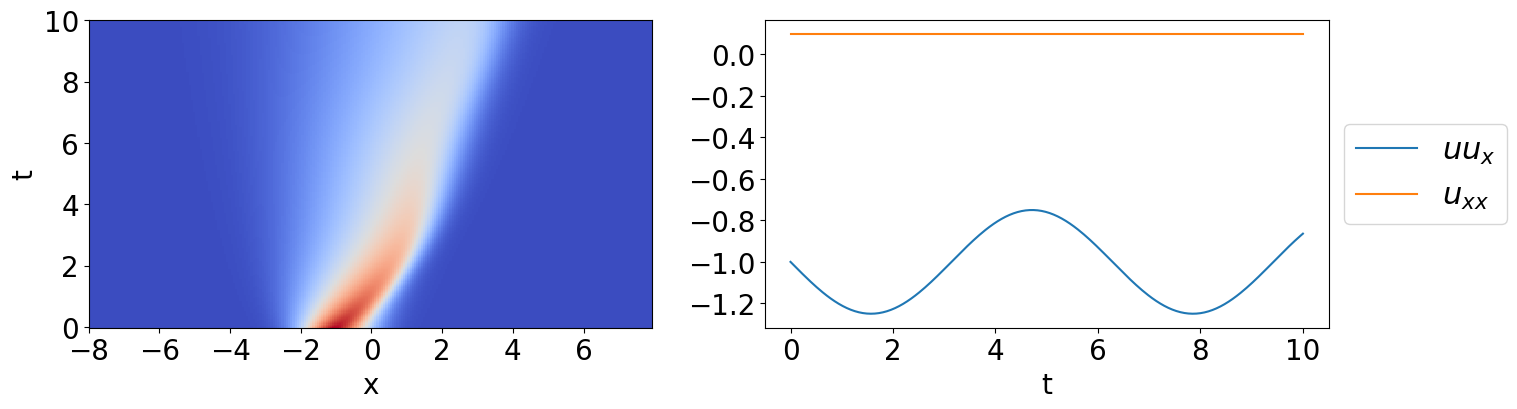

In [3]:
# Plot
fig=figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(t, uu_x_true, label=r'$uu_{x}$')
plot(t, u_xx_true, label=r'$u_{xx}$')

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('t', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [4]:
u_clean = u.copy()
u_clean_t = FinDiff(1, dt, 1, acc=4)(u_clean)
u_clean_x = FinDiff(0, dx, 1, acc=4)(u_clean)
u_clean_xx = FinDiff(0, dx, 1, acc=4)(u_clean_x)
u_clean_xxx = FinDiff(0, dx, 1, acc=4)(u_clean_xx)
u_clean_xxxx = FinDiff(0, dx, 1, acc=4)(u_clean_xxx)
noise_lv = 4 # 2, 4
noise_lv = abs(noise_lv)
u = u + 0.01*noise_lv*std(u)*np.random.randn(n, m)

In [5]:
include_bias = False
is_denoising = True

if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    u = savgol_filter(u, window_size, poly_order, axis=1)

ttt = u.copy()
alpha = 3e-4
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                              diff_kwargs, 
                                                                              include_bias=include_bias, 
                                                                              dependent='temporal')

# Theta_grouped, Ut_grouped = spatial_temporal_group(Theta, Ut, (n,m), "temporal")

# fs = (np.arange(len(t))/t)[1]

# f, P_clean = periodogram(u_clean_t, fs)
# fig=figure(figsize=(10,4))
# subplot(1,2,1)
# pcolor(*np.meshgrid(x, t), u_clean_t.T)
# xlabel('x', fontsize = fontsize)
# ylabel('t', fontsize = fontsize)
# subplot(1,2,2)
# pcolor(*np.meshgrid(x, f), P_clean.T, cmap=cm.coolwarm)
# xlabel('x', fontsize = fontsize)
# ylabel('f', fontsize = fontsize)
# plt.show()

# fig=figure(figsize=(10,4))
# subplot(1,2,1)
# Ut_rec = Ut.reshape(u.shape).T
# f, P = periodogram(Ut_rec, fs)
# pcolor(*np.meshgrid(x, t), Ut_rec.T)
# xlabel('x', fontsize = fontsize)
# ylabel('t', fontsize = fontsize)
# subplot(1,2,2)
# pcolor(*np.meshgrid(x, f), P.T, cmap=cm.coolwarm)
# xlabel('x', fontsize = fontsize)
# ylabel('f', fontsize = fontsize)
# plt.show()

In [6]:
fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(len(rhs_des))])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

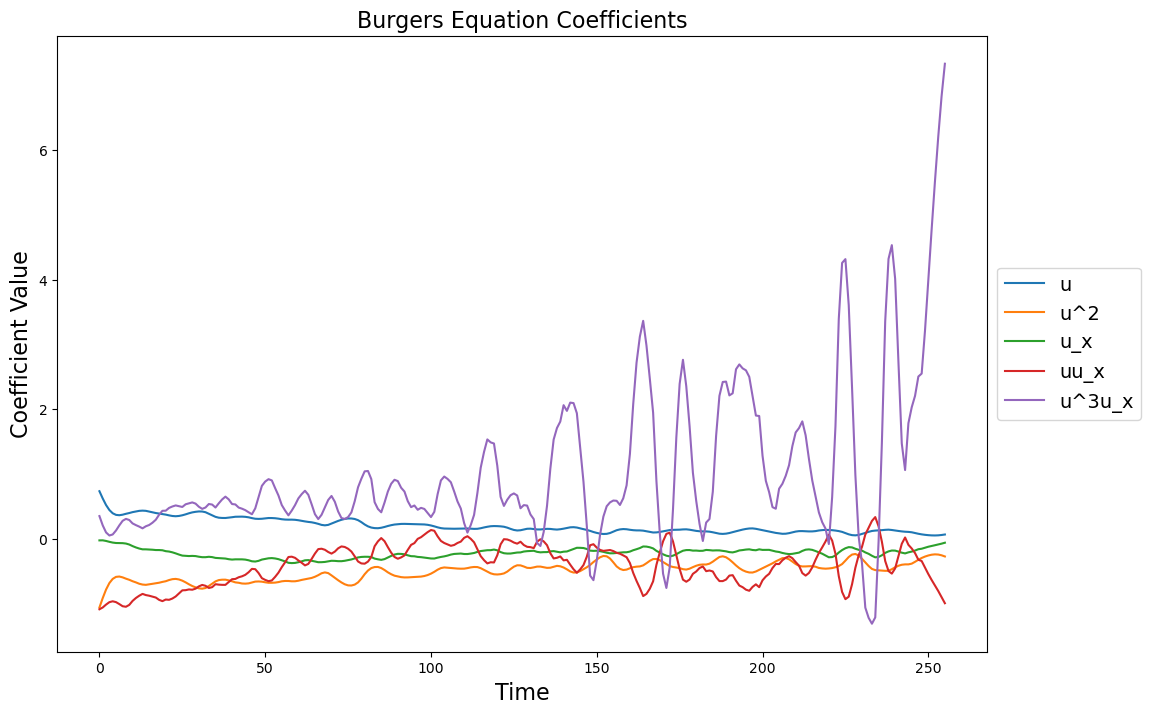

In [7]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped, normalize=2)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in np.where(np.linalg.norm(xi, axis=-1) > 1e-10)[0]:
    plot(xi[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

In [8]:
# 0.1821324868907128
# xi = xi[np.where(np.linalg.norm(xi, axis=-1))[0]]
xi = xi[[4, 7]]
errors = np.array([coeff_error(xi[0], u_xx_true), coeff_error(xi[1], uu_x_true)])
print(errors)
errors.mean(), errors.std()

[100.          61.20097074]


(80.60048537091185, 19.399514629088138)

In [9]:
candidates = {(0, 1, 2, 3, 4, 6, 7),
              (0, 1, 2, 3, 4, 7),
              (0, 1, 2, 3, 5, 6, 7, 11, 15),
              (0, 1, 2, 3, 5, 7, 11, 18),
              (0, 1, 2, 3, 7, 10, 11, 15, 16, 17),
              (0, 1, 3, 4, 7),
              (1, 2, 4, 7),
              (3,),
              (4, 7),
              (4, 7, 8)}
candidates = sorted(candidates, key=len)
rhs_des[4], rhs_des[7]

('u_xx', 'uu_x')

In [10]:
f_u_xx, f_uu_x = linear_fit_grouped_data((Theta_grouped, Ut_grouped), considered_indices=candidates[1])

In [11]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=100,  
    binary_operators=["+", "-", "*"],
    unary_operators=[
        "cos",
        "sin"
    ],
)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [12]:
model.fit(t.reshape(-1,1), f_uu_x.reshape(-1,1))

Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 3.470e+05
Head worker occupation: 24.1%
Progress: 742 / 1500 total iterations (49.467%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.133e-01  1.594e+01  y = -0.7181
2           3.061e-02  1.308e+00  y = sin(-1.5708)
3           3.058e-02  1.048e-03  y = 2.0814 * -0.48316
5           2.857e-02  3.399e-02  y = (0.015474 * x₀) - 1.083
6           2.584e-03  2.403e+00  y = -0.95987 + (sin(x₀) * -0.25146)
7           2.538e-03  1.827e-02  y = (sin(sin(x₀)) * -0.28536) + -0.95964
8           2.415e-03  4.962e-02  y = (-0.25162 * sin(x₀ * 1.0122)) + -0.96225
9           2.378e-03  1.520e-02  y = -0.96201 + (sin(sin(x₀ * 1.0115)) * -0.2853)
10          1.508e-03  4.553e-01  y = (0.011349 * x₀) + (-1.0173 + (sin(x₀) * -0.24788))
11          1.505e-03  2.001e-03  y = (-1.0172 + sin(sin(x₀) * -0.24986)) + (0.011332 * x₀)
12          1.384e

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         -0.7181005   
	1         1.308391                                    sin(-1.5707532)   
	2         0.001048                             2.0814364 * -0.4831641   
	3         0.033995                     (0.015474278 * x0) - 1.0830411   
	4         2.402846                -0.9598714 + (sin(x0) * -0.2514623)   
	5         0.018271          (sin(sin(x0)) * -0.28535277) + -0.9596359   
	6         0.049618  (-0.25161678 * sin(x0 * 1.0122267)) + -0.96224564   
	7         0.015203  -0.96200824 + (sin(sin(x0 * 1.0114661)) * -0.2...   
	8   >>>>  0.455335  (0.011348579 * x0) + (-1.017266 + (sin(x0) * -...   
	9         0.002001  (sin(-0.24985987 * sin(x0)) + -1.0171592) + (x...   
	10        0.083966  ((0.0011579911 * x0) * x0) + ((-0.2533426 * si...   
	11        0.002585  (-0.99813443 + sin(sin(x0) * -0.2554493)) - (x...   
	12        0.014197  (-0.9899693 + (-0.25587088 * sin(x0))) - ((x0 ...   
	13        0.002689  (-0.9899439 + sin(-0.25802544 * sin(x0))) - ((...   
	14        0.003635  ((-0.25802544 * sin(x0 - 0.030252172)) + -0.98...   
	15        0.023759  (((cos(x0 * 1.7941625) + x0) * x0) * 0.0011579...   
	16        0.000708  (((x0 + cos(x0 * 1.7941625)) * x0) * 0.0011579...   
	17        0.042120  ((sin(x0) * -0.24758732) + -1.0000677) - ((sin...   
	
	        loss  complexity  
	0   0.113273           1  
	1   0.030613           2  
	2   0.030580           3  
	3   0.028570           5  
	4   0.002584           6  
	5   0.002538           7  
	6   0.002415           8  
	7   0.002378           9  
	8   0.001508          10  
	9   0.001505          11  
	10  0.001384          12  
	11  0.001381          13  
	12  0.001361          14  
	13  0.001358          15  
	14  0.001353          16  
	15  0.001321          17  
	16  0.001320          18  
	17  0.001265          19  
]

In [13]:
model.fit(t.reshape(-1,1), f_u_xx.reshape(-1,1))

[ Info: Started!



Expressions evaluated per second: 4.150e+05
Head worker occupation: 21.9%
Progress: 888 / 1500 total iterations (59.200%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.677e+00  1.594e+01  y = -2.0818
2           3.659e-04  9.454e+00  y = sin(0.080887)
5           3.084e-04  5.705e-02  y = 0.10068 - (0.0020476 * x₀)
6           1.210e-04  9.359e-01  y = sin((x₀ * -0.0054154) + 0.10797)
7           1.203e-04  5.213e-03  y = sin(cos(0.10748 * x₀) * 0.098905)
8           1.192e-04  9.137e-03  y = (0.037764 * cos(x₀ * -0.19016)) - -0.062043
9           1.176e-04  1.352e-02  y = sin(0.10373 * cos((x₀ - -2.0492) * 0.089698))
10          1.140e-04  3.172e-02  y = sin(cos(0.11051 * (sin(x₀) - x₀)) * 0.09903)
11          1.123e-04  1.474e-02  y = sin(cos(0.11051 * (sin(sin(x₀)) - x₀)) * 0.09903)
12          1.058e-04  5.963e-02  y = sin(0.10031 * cos(-0.11385 * (sin(-0.557

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         -2.0817535   
	1         9.455717                                   sin(0.080887355)   
	2         0.057047                   0.10067869 - (0.0020475765 * x0)   
	3   >>>>  0.935868              sin((x0 * -0.0054153935) + 0.1079679)   
	4         0.005213             sin(cos(0.10748441 * x0) * 0.09890508)   
	5         0.009137  (0.037763584 * cos(x0 * -0.19015868)) - -0.062...   
	6         0.013516  sin(0.10373433 * cos((x0 - -2.0491805) * 0.089...   
	7         0.031722  sin(cos(0.110509396 * (sin(x0) - x0)) * 0.0990...   
	8         0.014736  sin(cos(0.110509396 * (sin(sin(x0)) - x0)) * 0...   
	9         0.060953  sin(0.10031191 * cos(-0.11385282 * (sin(-0.706...   
	10        0.000149  sin(cos(-0.11385282 * (sin(sin(-0.55707645 + x...   
	11        0.000483  sin(0.10031191 * cos(-0.11385282 * ((sin(-0.70...   
	12        0.038970  sin(0.10067869 * cos(-0.11385282 * (sin((sin(x...   
	13        0.003897  sin(0.10067869 * cos(-0.11385282 * (sin(((sin(...   
	14        0.001863  sin(0.10067869 * cos(sin(-0.11385282) * (sin((...   
	15        0.015483  sin(0.10067869 * cos(-0.11385282 * ((sin(((sin...   
	16        0.000989  sin(sin(0.10067869 * cos(-0.11385282 * ((sin((...   
	
	        loss  complexity  
	0   4.676999           1  
	1   0.000366           2  
	2   0.000308           5  
	3   0.000121           6  
	4   0.000120           7  
	5   0.000119           8  
	6   0.000118           9  
	7   0.000114          10  
	8   0.000112          11  
	9   0.000106          12  
	10  0.000106          13  
	11  0.000106          14  
	12  0.000102          15  
	13  0.000101          17  
	14  0.000101          18  
	15  0.000099          19  
	16  0.000099          20  
]

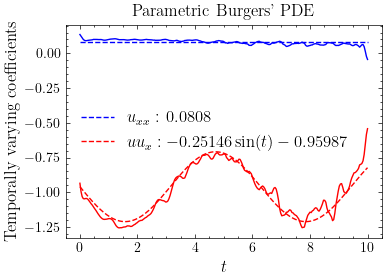

In [32]:
y1 = -0.9598714 + (sin(t) * -0.2514623)
y2 = sin(0.080887355)*np.ones(len(t))
fs = 12
with plt.style.context('science'):
    plt.figure(figsize=(4, 3))
    plt.plot(t, f_u_xx, '-', c='blue')
    plt.plot(t, y2, '--', c='blue', label='$u_{xx}:\, 0.0808$')
    plt.plot(t, f_uu_x, '-', c='red')
    plt.plot(t, y1, '--', c='red', label='$uu_{x}: -0.25146\sin(t)-0.95987$')
    plt.ylabel('Temporally varying coefficients', fontsize=fs)
    plt.xlabel('$t$', fontsize=fs)
    plt.title("Parametric Burgers' PDE", fontsize=fs)
    plt.legend(fontsize=fs)
    plt.tight_layout()
    # plt.savefig(f"/Users/pongpisit/Documents/latex/UBIC-ACML/figures/burgers_vc_noise{noise_lv}.pdf")
    plt.show()